In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/LandslideDetection/data'

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_images_path = os.path.join(data_dir, "train/images/")
train_masks_path = os.path.join(data_dir, "train/masks/")

In [ ]:
image_files = sorted(os.listdir(train_images_path))
mask_files = sorted(os.listdir(train_masks_path))

In [ ]:
# Read one image and its corresponding mask
image_path = os.path.join(train_images_path, image_files[0])
mask_path = os.path.join(train_masks_path, mask_files[0])

In [ ]:
# Load using OpenCV (or PIL)
image = cv2.imread(image_path)  # Reads as BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

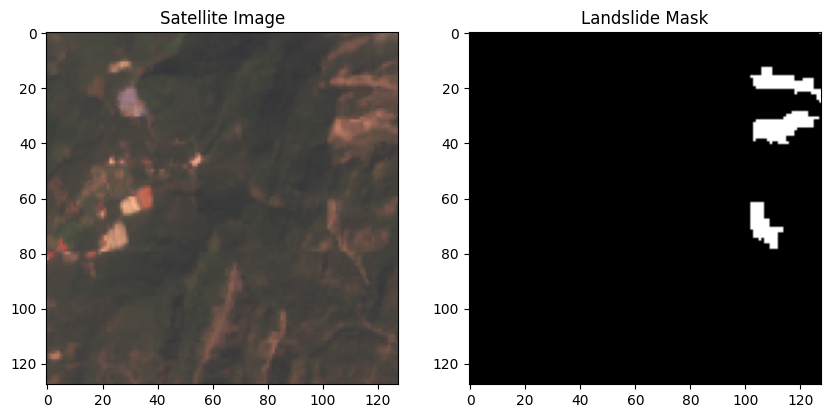

In [ ]:
# Show the image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Satellite Image")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Landslide Mask")
plt.show()

In [ ]:
import os
import cv2
import numpy as np

# Define paths
data_dir = '/content/drive/MyDrive/LandslideDetection/data'
train_images_path = os.path.join(data_dir, "train/images/")
train_masks_path = os.path.join(data_dir, "train/masks/")

# Get sorted list of image and mask files
image_files = sorted(os.listdir(train_images_path))
mask_files = sorted(os.listdir(train_masks_path))

# Initialize arrays for storing images and masks
images = []
masks = []

# Loop through image and mask files to load, resize, and append
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(train_images_path, img_file)
    mask_path = os.path.join(train_masks_path, mask_file)

    # Read image and mask
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if image and mask are loaded properly
    if img is None:
        print(f"Error loading image: {img_path}")
        continue
    if mask is None:
        print(f"Error loading mask: {mask_path}")
        continue

    # Resize image and mask to 256x256
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    # Normalize image
    img = img / 255.0  # Scale to range 0-1

    # Normalize mask and convert to binary (0 or 1)
    mask = mask / 255.0
    mask = np.where(mask > 0.5, 1, 0)  # Ensure binary values (0 or 1)

    # Add the image and mask to their respective arrays
    images.append(img)
    masks.append(mask)

# Convert lists to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.uint8)

# Check shapes
print("Images shape:", images.shape)  # Should be (204, 256, 256, 3)
print("Masks shape:", masks.shape)    # Should be (204, 256, 256, 1)

Images shape: (1385, 256, 256, 3)
Masks shape: (1385, 256, 256)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `images` and `masks` are lists or arrays of processed images and masks
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# Add an extra channel to y_train and y_test
y_train = np.expand_dims(y_train, axis=-1)  # Shape becomes (n_train, 256, 256, 1)
y_val = np.expand_dims(y_val, axis=-1)    # Shape becomes (n_test, 256, 256, 1)

# Print the new shapes
print(f"New y_train shape: {y_train.shape}")
print(f"New y_val shape: {y_val.shape}")

New y_train shape: (1108, 256, 256, 1)
New y_val shape: (277, 256, 256, 1)


In [ ]:
print("X_train shape:", X_train.shape)  # Should be (204, 256, 256, 3)
print("y_train shape:", y_train.shape)  # Should be (204, 256, 256, 1)

X_train shape: (1108, 256, 256, 3)
y_train shape: (1108, 256, 256, 1)


In [ ]:
import tensorflow as tf

def data_generator(X, y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X))  # Shuffle the dataset
    dataset = dataset.batch(batch_size)  # Batch the dataset
    return dataset

# Create datasets for training and validation
batch_size = 8  # You can adjust the batch size
train_dataset = data_generator(X_train, y_train, batch_size)
val_dataset = data_generator(X_val, y_val, batch_size)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Build Model
def SegNet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    x = inputs

    # Encoder
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Decoder
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation="sigmoid")(x)

    return Model(inputs, outputs)

# Instantiate model
model = SegNet()
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype='float32')  # Ensure same dtype
    y_pred = K.cast(y_pred, dtype='float32')

    y_pred = K.round(y_pred)  # Convert probabilities to binary (0 or 1)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return 1 - (intersection + smooth) / (union + smooth)  # IoU loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)


# Compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
optimizer = Adam(learning_rate=0.0001)  # Reduce from default 0.001 to 0.0001

#model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=optimizer,  loss=iou_loss, metrics=["accuracy", iou_metric])
model.compile(optimizer=optimizer, loss=dice_loss, metrics=["accuracy", iou_metric])

# Summary of the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 256)         │           1,0

 Total params: 2,072,589 (7.91 MB)

 Trainable params: 2,070,023 (7.90 MB)

 Non-trainable params: 2,566 (10.02 KB)

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - accuracy: 0.7726 - iou_metric: 0.2203 - loss: 0.7756 - val_accuracy: 0.9570 - val_iou_metric: 5.6254e-11 - val_loss: 0.9399
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9260 - iou_metric: 0.3248 - loss: 0.7045 - val_accuracy: 0.9570 - val_iou_metric: 1.6554e-04 - val_loss: 0.9409
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - accuracy: 0.9367 - iou_metric: 0.3604 - loss: 0.6606 - val_accuracy: 0.9609 - val_iou_metric: 0.1369 - val_loss: 0.8374
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 200ms/step - accuracy: 0.9418 - iou_metric: 0.3852 - loss: 0.6145 - val_accuracy: 0.9611 - val_iou_metric: 0.3640 - val_loss: 0.6476
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step - accuracy: 0.9470 - iou_metric: 0.3893 - loss: 0.5981 - val_accuracy: 0.9160 - val_iou_metric: 0.3151 - val_loss: 0.6206
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - accuracy: 0.9480 - iou_metric: 0.4107 - loss: 0.55

In [ ]:
def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Convert to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Convert to float32

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

In [ ]:
loss, iou_score = model.evaluate(X_val, y_val, batch_size=8)  # Adjust batch size if needed
print(f"Test Loss: {loss:.4f}")
print(f"Test IoU: {iou_score:.4f}")  # IoU score

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - iou: 0.4422 - loss: 0.2516
Test Loss: 0.2558
Test IoU: 0.4269


In [ ]:
new_image = tf.io.read_file('/content/drive/MyDrive/LandslideDetection/data/test/images/image_366.png')

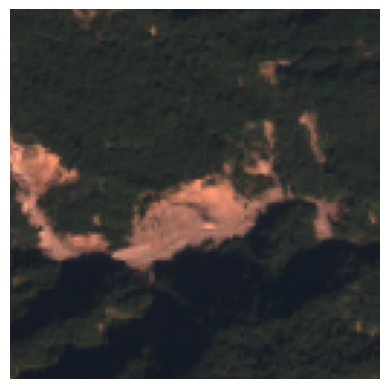

In [ ]:
#display selected test image
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the image
new_image_path = '/content/drive/MyDrive/LandslideDetection/data/test/images/image_12.png'
new_image = tf.io.read_file(new_image_path)

# Decode the image to a tensor
new_image = tf.image.decode_png(new_image, channels=3)  # Use channels=3 for RGB images

# Convert the tensor to a numpy array
new_image = new_image.numpy()

# Display the image
plt.imshow(new_image)
plt.axis('off')  # Optional: To remove the axis
plt.show()

In [ ]:
# Load the image
new_image_path = '/content/drive/MyDrive/LandslideDetection/data/test/images/image_12.png'
new_image = tf.io.read_file(new_image_path)

# Assuming the image is a PNG based on its extension
new_image = tf.image.decode_png(new_image, channels=3)

new_image = tf.image.convert_image_dtype(new_image, dtype=tf.float32)
# Resize to match input shape
new_image = tf.image.resize(new_image, (256, 256))

# Add batch dimension
new_image = tf.expand_dims(new_image, axis=0)

In [ ]:
prediction = model.predict(new_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [ ]:
#prediction = tf.squeeze(prediction)
prediction = np.reshape(prediction, (256, 256))
prediction = tf.round(prediction)

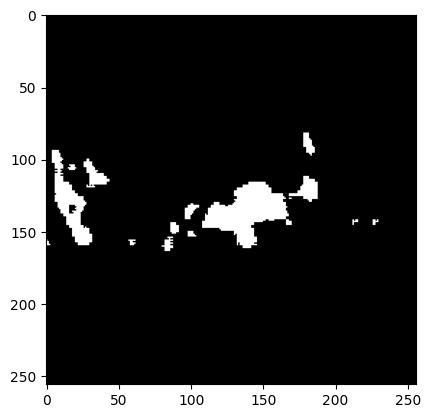

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(prediction, cmap='gray')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


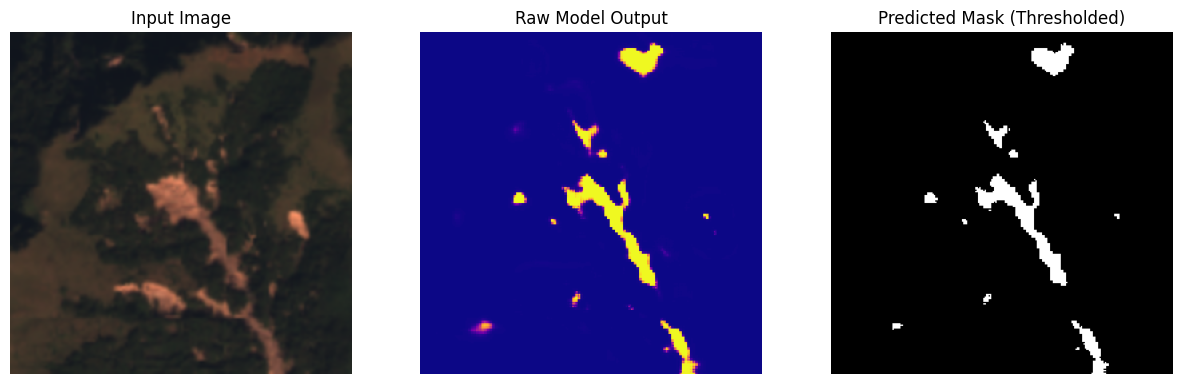

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_and_visualize(model, image_path):
    """
    Loads an image, preprocesses it, performs prediction, and visualizes:
    - Input Image
    - Raw Model Output
    - Predicted Mask (thresholded)

    Args:
    - model: Trained TensorFlow/Keras model
    - image_path: Path to the input image

    Returns:
    - input_image: Preprocessed input image
    - raw_output: Raw model output
    - predicted_mask: Thresholded mask (binary)
    """

    # Load and preprocess the image
    new_image = tf.io.read_file(image_path)
    new_image = tf.image.decode_png(new_image, channels=3)  # Decode PNG (3 channels)
    new_image = tf.image.convert_image_dtype(new_image, dtype=tf.float32)  # Normalize to [0,1]
    new_image = tf.image.resize(new_image, (256, 256))  # Resize to match model input
    input_image = new_image.numpy()  # Convert to NumPy for visualization

    # Add batch dimension for model prediction
    new_image = tf.expand_dims(new_image, axis=0)

    # Perform prediction
    raw_output = model.predict(new_image)[0]  # Remove batch dimension

    # Ensure output is grayscale (if not already)
    if raw_output.shape[-1] == 1:
        raw_output = np.squeeze(raw_output, axis=-1)

    # Apply threshold to convert to binary mask
    predicted_mask = np.where(raw_output > 0.5, 1, 0)  # Binary mask

    # Display images side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(input_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(raw_output, cmap="plasma")
    axes[1].set_title("Raw Model Output")
    axes[1].axis("off")

    axes[2].imshow(predicted_mask, cmap="gray")
    axes[2].set_title("Predicted Mask (Thresholded)")
    axes[2].axis("off")

    plt.show()

    return input_image, raw_output, predicted_mask

# Example Usage:
# ✅ Load SegNet Model
model = tf.keras.models.load_model("/content/drive/MyDrive/LandslideDetection/SegNet_model.h5")
image_path = "/content/drive/MyDrive/LandslideDetection/data/validate/images/image_9.png"
input_image, raw_output, predicted_mask = predict_and_visualize(model, image_path)

In [ ]:
# Define the path where you want to save the model
save_path = "/content/drive/MyDrive/LandslideDetection/SegNet_model.h5"

# Save the entire model
model.save(save_path)
print(f"Model saved at: {save_path}")

Model saved at: /content/drive/MyDrive/LandslideDetection/SegNet_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step

Confusion Matrix:
 [[12261403   176977]
 [  232662   370622]]

Accuracy: 0.9685899744081736
Precision: 0.6768127772329752
Recall: 0.6143408411295509
F1 Score: 0.644065469730633


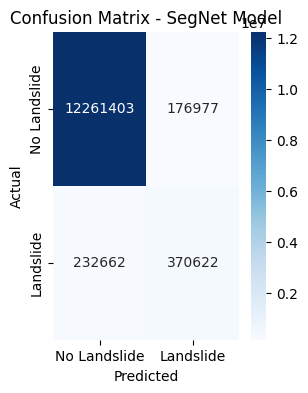


Total Landslide Pixels (Ground Truth): 603284
Total Landslide Pixels (Predicted): 547599


In [ ]:
import numpy as np
import cv2
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ✅ Load SegNet Model
model = tf.keras.models.load_model("/content/drive/MyDrive/LandslideDetection/SegNet_model.h5")

# ✅ Define paths
test_images_path = "/content/drive/MyDrive/LandslideDetection/data/test/images/"
test_masks_path = "/content/drive/MyDrive/LandslideDetection/data/test/masks/"

# ✅ Load and preprocess images
image_files = sorted(os.listdir(test_images_path))
mask_files = sorted(os.listdir(test_masks_path))

test_images = []
test_masks = []

for img_file, mask_file in zip(image_files, mask_files):
    # Load image and mask
    img = cv2.imread(os.path.join(test_images_path, img_file))
    mask = cv2.imread(os.path.join(test_masks_path, mask_file), cv2.IMREAD_GRAYSCALE)

    # Resize and normalize
    img = cv2.resize(img, (256, 256)) / 255.0
    mask = cv2.resize(mask, (256, 256))

    # Convert mask to binary (0 or 1)
    mask = np.where(mask > 127, 1, 0).astype(np.uint8)

    test_images.append(img)
    test_masks.append(mask)

test_images = np.array(test_images, dtype=np.float32)  # (N, 256, 256, 3)
test_masks = np.array(test_masks, dtype=np.uint8)  # (N, 256, 256)

# ✅ Get model predictions
pred_masks = model.predict(test_images)  # Output: (N, 256, 256, 1)
pred_masks = np.where(pred_masks > 0.3, 1, 0).astype(np.uint8)  # Binarize predictions

# ✅ Flatten labels and predictions
y_true = test_masks.flatten()
y_pred = pred_masks.flatten()

# ✅ Compute metrics
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)

# ✅ Print results
print("\nConfusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(3, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Landslide', 'Landslide'], yticklabels=['No Landslide', 'Landslide'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SegNet Model")
plt.show()

# ✅ Visualize some predictions
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# for i in range(3):
#     axes[i, 0].imshow(test_images[i])
#     axes[i, 0].set_title("Input Image")
#     axes[i, 0].axis("off")

#     axes[i, 1].imshow(pred_masks[i], cmap='plasma')
#     axes[i, 1].set_title("Raw Prediction")
#     axes[i, 1].axis("off")

#     axes[i, 2].imshow(test_masks[i], cmap='gray')
#     axes[i, 2].set_title("Ground Truth Mask")
#     axes[i, 2].axis("off")

# plt.show()

# ✅ Additional Debugging (Check Class Balance)
print(f"\nTotal Landslide Pixels (Ground Truth): {np.sum(y_true)}")
print(f"Total Landslide Pixels (Predicted): {np.sum(y_pred)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

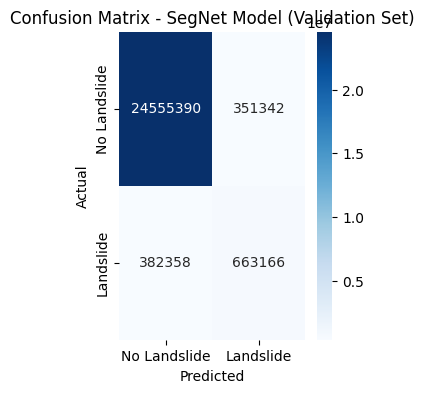

In [ ]:
import numpy as np
import cv2
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load SegNet Model
model = tf.keras.models.load_model("/content/drive/MyDrive/LandslideDetection/SegNet_model.h5")

# ✅ Define paths
val_images_path = "/content/drive/MyDrive/LandslideDetection/data/validate/images/"
val_masks_path = "/content/drive/MyDrive/LandslideDetection/data/validate/masks/"

# ✅ Initialize confusion matrix accumulators
TN_total, FP_total, FN_total, TP_total = 0, 0, 0, 0

# ✅ Process validation images
image_files = sorted(os.listdir(val_images_path))
mask_files = sorted(os.listdir(val_masks_path))

for img_file, mask_file in zip(image_files, mask_files):
    # Load image and mask
    img = cv2.imread(os.path.join(val_images_path, img_file))
    mask = cv2.imread(os.path.join(val_masks_path, mask_file), cv2.IMREAD_GRAYSCALE)

    # Resize and normalize
    img = cv2.resize(img, (256, 256)) / 255.0
    mask = cv2.resize(mask, (256, 256))
    mask = np.where(mask > 127, 1, 0).astype(np.uint8)  # Convert to binary

    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Get model prediction
    pred_mask = model.predict(img)[0, :, :, 0]  # Remove batch dimension
    pred_mask = np.where(pred_mask > 0.3, 1, 0).astype(np.uint8)  # Convert to binary mask

    # Compute confusion matrix values
    TN = np.sum((mask == 0) & (pred_mask == 0))
    TP = np.sum((mask == 1) & (pred_mask == 1))
    FP = np.sum((mask == 0) & (pred_mask == 1))
    FN = np.sum((mask == 1) & (pred_mask == 0))

    # Accumulate values
    TN_total += TN
    TP_total += TP
    FP_total += FP
    FN_total += FN

# ✅ Compute overall metrics
accuracy = (TP_total + TN_total) / (TP_total + TN_total + FP_total + FN_total)
precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
recall = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# ✅ Print results
print("\nConfusion Matrix (Total):")
print(f"TN: {TN_total}, FP: {FP_total}")
print(f"FN: {FN_total}, TP: {TP_total}")
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# ✅ Plot Confusion Matrix
total_conf_matrix = np.array([[TN_total, FP_total], [FN_total, TP_total]])
plt.figure(figsize=(3, 4))
sns.heatmap(total_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Landslide', 'Landslide'],
            yticklabels=['No Landslide', 'Landslide'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SegNet Model (Validation Set)")
plt.show()
